In [4]:
# input: original sensitivity image, original attenuation image and transformed attenuation image
%matplotlib widget

# Setup the working directory for the notebook
#import notebook_setup
#from sirf_exercises import cd_to_working_dir
#cd_to_working_dir('Synergistic', 'BrainWeb_single_slice')

import os
import brainweb
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
logging.basicConfig(level=logging.INFO)
import nibabel as nib
import sirf.STIR as pet
import matplotlib.pyplot as plt
import os
import sirf.Reg as reg
from math import cos, sin, pi, radians
from sirf.Utilities import examples_data_path
#from sirf_exercises import exercises_data_path
import shutil
#from scipy.ndimage.filters import gaussian_filter

import os
import sys
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import brainweb
import sirf.STIR as stir

import brainweb
import os
import numpy as np
import sirf.STIR as stir
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import sirf.STIR as stir
import sirf.Reg as reg
import numpy as np
import os
import sys
# add the source directory to the path
# This is to make everything nice and self-contained
dir_path = os.path.dirname(os.getcwd())
source_path = os.path.join(dir_path, 'source')
sys.path.append(source_path)

from reconstruction.reconstruction import *
from reconstruction.registration import *
from reconstruction.osem import *
from plotting_functions import plot_2d_image

# and some additional functions for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import imageio
from plotting_functions import *
from IPython.display import Image
import torch
import os
import sys
# load model 
path_to_data = os.path.join(os.path.dirname(os.getcwd()), 'source', 'models')
sys.path.append(path_to_data)

from models.UNet import UNet


model = UNet(in_channels=2, n_class=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/home/sirfuser/devel/PET_sensitivity/data/trained_models/grid_VanillaCNN_lr0.01_bs32_e20/final_model.pth"

# Save model 
torch.save(model.state_dict(), model_path)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
else:
    print(f"Model file not found at {model_path}")

Model loaded from /home/sirfuser/devel/PET_sensitivity/data/trained_models/grid_VanillaCNN_lr0.01_bs32_e20/final_model.pth


In [11]:
from torch.utils.data import Dataset
import torch

class BrainWebTestDataset(Dataset):
    def __init__(self, sens_images, attn_images):
        self.sens_images = sens_images 
        self.attn_images = attn_images  

    def __len__(self):
        return len(self.sens_images)

    def __getitem__(self, idx):
        sens = self.sens_images[idx]
        attn = self.attn_images[idx]

        # apply affine transformation
        transformed_sens, transformed_attn = generate_transformed_image(sens, attn) 
        
        # inputs 
        x_sens = sens.as_array().squeeze()
        x_attn = transformed_attn.as_array().squeeze()
        x = np.array([x_sens, x_attn])  # shape: [2, H, W]

        y = transformed_sens.as_array().squeeze(0)  # shape: [H, W]

        return x, y


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

/tmp/ipykernel_2611/3235935015.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 2))


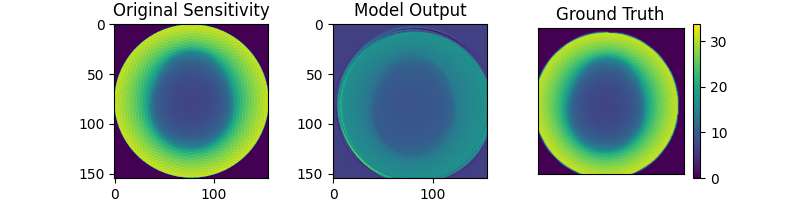

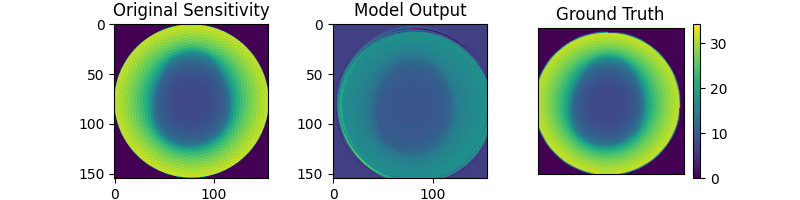

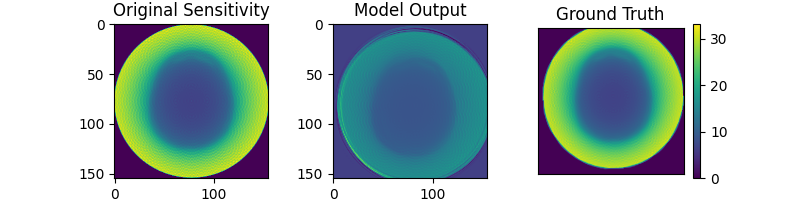

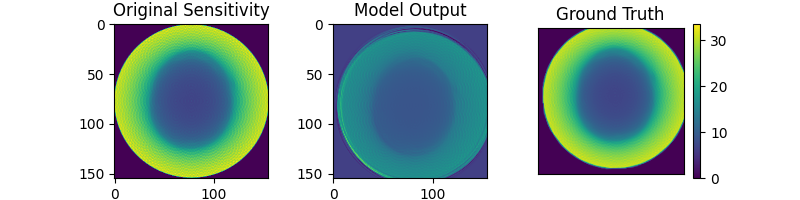

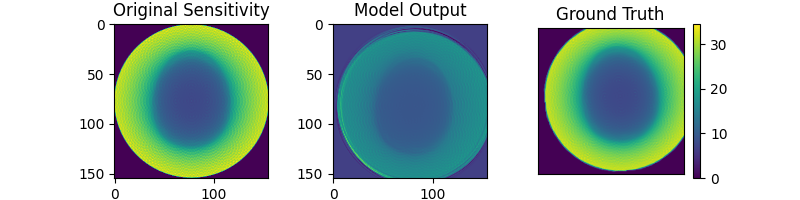

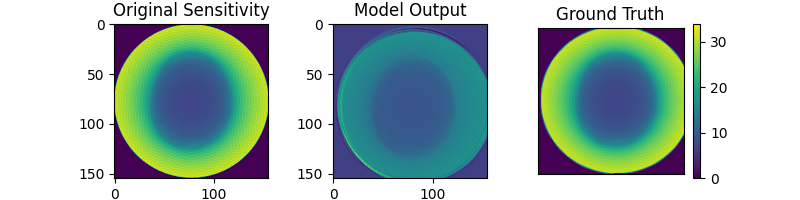

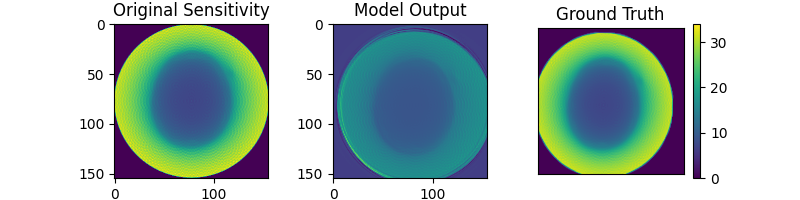

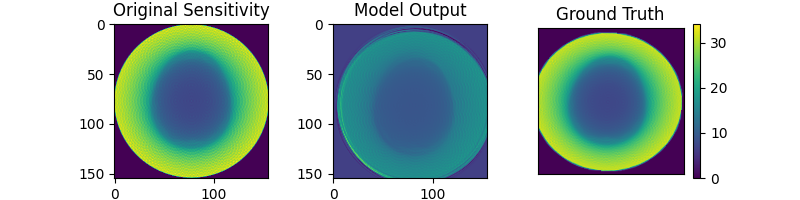

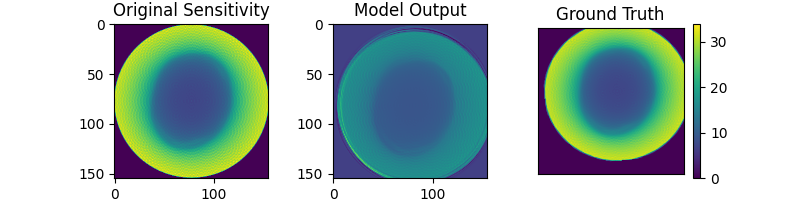

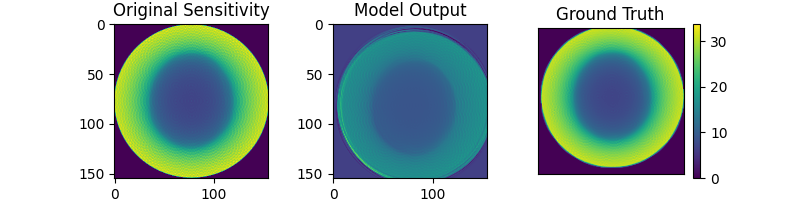

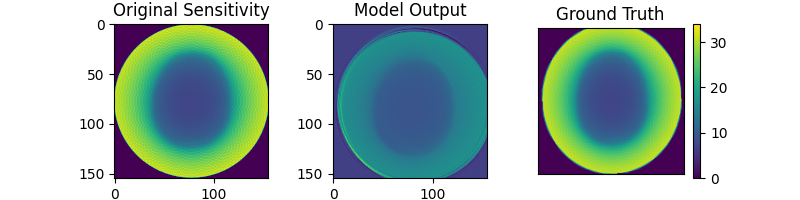

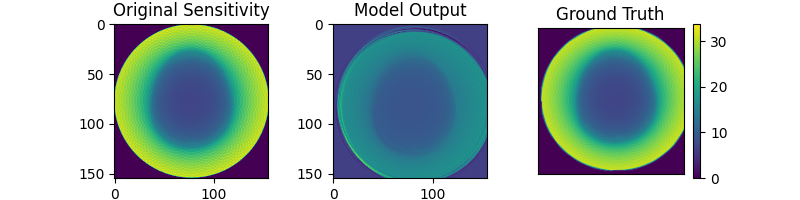

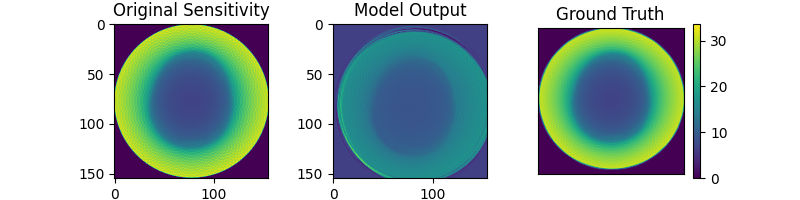

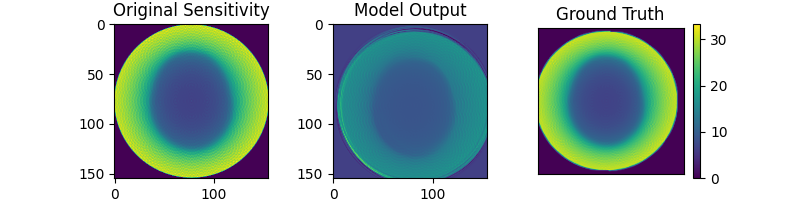

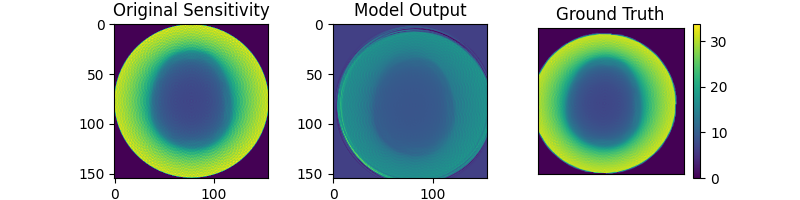

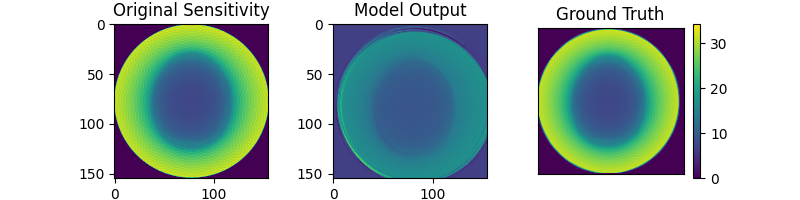

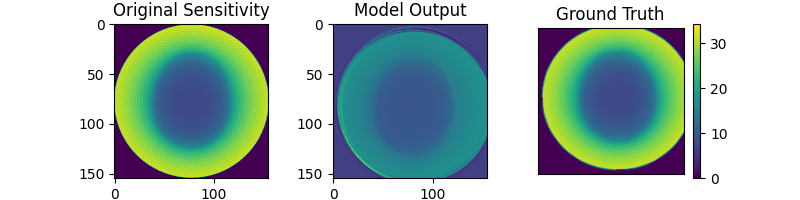

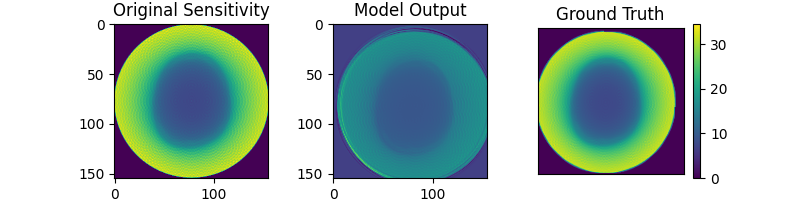

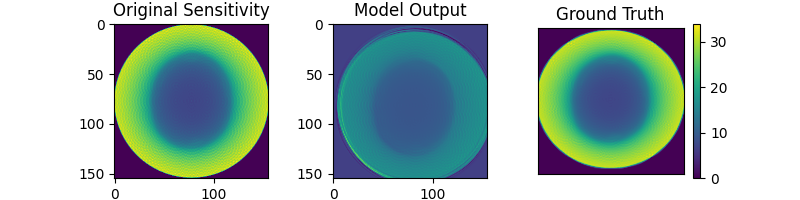

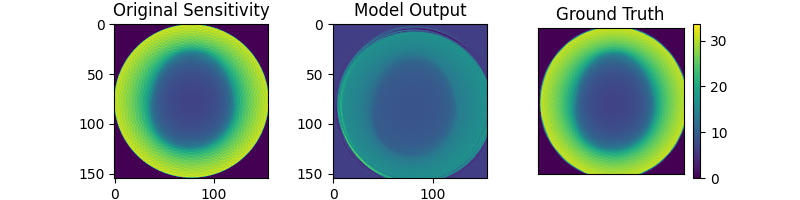

In [17]:
from torch.utils.data import DataLoader

dir_path = os.path.dirname(os.getcwd())
output_dir = os.path.join(dir_path, 'data', 'processed')


sens_images = []
attn_images = []

for i in range(20):  
    sens = stir.ImageData(os.path.join(output_dir, f'sens_{i}.hv'))
    attn = stir.ImageData(os.path.join(output_dir, f'attn_{i}.hv'))
    sens_images.append(sens)
    attn_images.append(attn)

# Assume you have lists of original sensitivity and attenuation images
test_dataset = BrainWebTestDataset(sens_images, attn_images)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        vmax = max([X[0, 0].max(), y[0].max()])
        print(X)
        out = model(X)

        plt.figure(figsize=(8, 2))
        plt.subplot(1, 3, 1)
        plt.imshow(X[0, 0].detach().cpu().numpy(), vmax=vmax)  
        plt.title('Original Sensitivity')

        plt.subplot(1, 3, 2)
        plt.imshow(out[0, 0].detach().cpu().numpy(), vmax=vmax)  
        plt.title('Model Output')

        plt.subplot(1, 3, 3)
        plt.imshow(y[0].detach().cpu().numpy(), vmax=vmax)  
        plt.title('Ground Truth')

        plt.xticks([]); plt.yticks([])
        plt.colorbar()

